In [29]:
import pandas as pd


h = pd.read_csv("h_v4.csv")
h = h.sample(100)
h

,y_relaxed,bulk_symbols,composition,structure,mp_material_id,mp_volume,mp_density,mp_energy_per_atom,mp_formation_energy_per_atom,mp_band_gap,...,max relative bond length,min relative bond length,minimum neighbor distance variation,maximum neighbor distance variation,range neighbor distance variation,mean neighbor distance variation,avg_dev neighbor distance variation,mean absolute deviation in relative cell size,structural complexity per atom,structural complexity per cell
658,-268.048852,Mn2Nb2O8,Mn2 Nb2 O8,Full Formula (Mn2 Nb2 O8)\nReduced Formula: Mn...,mp-754809,155.691013,4.518847,-9.066667,-2.557473,0.0000,...,1.082690,0.821777,0.019812,1.873465e-01,1.675343e-01,1.284533e-01,6.539904e-02,2.156085e-01,1.918296,23.019550
1011,-557.088828,Bi2Au2O4,Bi2 Au2 O4,Full Formula (Bi2 Au2 O4)\nReduced Formula: Bi...,mp-997082,145.642010,9.986488,-5.382936,-1.117976,1.0829,...,1.099268,0.956464,0.126932,2.512343e-01,1.243024e-01,1.718528e-01,3.969076e-02,1.411476e-01,2.000000,16.000000
575,-246.736476,Sr1Sb1O3,Sr1 Sb1 O3,Full Formula (Sr1 Sb1 O3)\nReduced Formula: Sr...,mp-1187192,74.547870,5.733048,-6.508669,-2.375606,0.0000,...,1.116672,0.789606,0.000000,1.224077e-01,1.224077e-01,7.344465e-02,5.875572e-02,1.500000e-01,1.370951,6.854753
524,-405.608416,Mg3Cd1O4,Mg3 Cd1 O4,Full Formula (Mg3 Cd1 O4)\nReduced Formula: Mg...,mp-1099255,87.921726,4.708865,-5.691950,-2.486542,1.8327,...,1.000000,1.000000,0.000000,1.997414e-16,1.997414e-16,1.498061e-16,7.490304e-17,1.414269e-16,1.811278,14.490225
601,-339.697396,Ba1Pd1O3,Ba1 Pd1 O3,Full Formula (Ba1 Pd1 O3)\nReduced Formula: Ba...,mp-1178510,70.356355,6.885722,-6.073839,-1.685291,0.0000,...,1.116672,0.789606,0.000000,1.224077e-01,1.224077e-01,7.344465e-02,5.875572e-02,1.500000e-01,1.370951,6.854753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,-510.002041,Ti12O20,Ti12 O20,Full Formula (Ti6 O10)\nReduced Formula: Ti3O5...,mp-8057,185.545189,4.002186,-9.435419,-3.382134,0.0000,...,1.099078,0.865193,0.037558,2.054443e-01,1.678867e-01,1.335604e-01,6.699692e-02,1.937918e-01,2.250000,36.000000
816,-606.495354,Nb1V3O10,Nb1 V3 O10,Full Formula (Nb1 V3 O10)\nReduced Formula: Nb...,mp-776661,203.512484,3.310470,-8.622576,-2.420245,1.5159,...,1.197188,0.739757,0.078701,1.943774e-01,1.156769e-01,1.605166e-01,3.559239e-02,2.306994e-01,2.378783,33.302969
253,-788.446741,Al8Bi4O18,Al8 Bi4 O18,Full Formula (Al8 Bi4 O18)\nReduced Formula: A...,mp-23426,356.748336,6.236130,-7.344153,-2.857885,2.8002,...,1.160380,0.804308,0.016371,2.799870e-01,2.636157e-01,1.617895e-01,5.575169e-02,1.791574e-01,2.706891,81.206718
1090,-419.271205,Sr6Si6O18,Sr6 Si6 O18,Full Formula (Sr6 Si6 O18)\nReduced Formula: S...,mp-3978,447.855710,3.641839,-7.833552,-3.441226,4.6251,...,1.131146,0.673171,0.035213,2.296097e-01,1.943971e-01,1.443874e-01,8.527014e-02,2.092896e-01,3.106891,93.206718


In [30]:
import numpy as np
from pymatgen.analysis.local_env import CrystalNN

def compute_surface_features(structure):
    """
    Compute features specific to surface/adsorbate systems.
    
    Key idea: In OC22, structures have a slab (catalyst surface) + adsorbate.
    Surface atoms have different properties than bulk atoms.
    """
    features = {}
    
    # Get atomic positions
    coords = structure.cart_coords  # Cartesian coordinates
    z_coords = coords[:, 2]  # z-direction (usually perpendicular to surface)
    
    # === Z-direction features (surface geometry) ===
    features['z_span'] = z_coords.max() - z_coords.min()  # Thickness of system
    features['z_mean'] = z_coords.mean()  # Center of mass in z
    features['z_std'] = z_coords.std()  # Spread in z-direction
    features['z_skewness'] = ((z_coords - z_coords.mean())**3).mean() / (z_coords.std()**3)
    
    # === Atom counts ===
    features['num_atoms'] = len(structure)
    
    # === Surface atom identification ===
    # Atoms in top 20% of z are likely surface/adsorbate
    z_threshold_top = np.percentile(z_coords, 80)
    surface_mask = z_coords >= z_threshold_top
    features['num_surface_atoms'] = surface_mask.sum()
    features['surface_atom_ratio'] = surface_mask.sum() / len(structure)
    
    # Atoms in bottom 20% are deep bulk
    z_threshold_bottom = np.percentile(z_coords, 20)
    bulk_mask = z_coords <= z_threshold_bottom
    features['num_bulk_atoms'] = bulk_mask.sum()
    
    # === Surface atom types ===
    # Count different elements on surface
    surface_elements = [structure[i].species_string for i in range(len(structure)) if surface_mask[i]]
    unique_surface_elements = len(set(surface_elements))
    features['num_surface_element_types'] = unique_surface_elements
    
    # === Adsorbate detection (very undercoordinated atoms) ===
    cnn = CrystalNN()
    coord_nums = []
    for i in range(len(structure)):
        try:
            cn = cnn.get_cn(structure, i, use_weights=False)
            coord_nums.append(cn)
        except:
            coord_nums.append(0)
    
    # Atoms with coordination < 4 are likely adsorbate or very exposed surface
    features['num_low_coord_atoms'] = sum(1 for cn in coord_nums if cn < 4)
    features['min_coordination'] = min(coord_nums) if coord_nums else 0
    
    # === Surface roughness ===
    # Standard deviation of surface atom z-coordinates
    surface_z = z_coords[surface_mask]
    if len(surface_z) > 0:
        features['surface_roughness'] = surface_z.std()
        features['surface_z_range'] = surface_z.max() - surface_z.min()
    else:
        features['surface_roughness'] = 0
        features['surface_z_range'] = 0
    
    # === Layering ===
    # Count distinct layers (cluster z-coordinates)
    from scipy.cluster.hierarchy import fclusterdata
    if len(z_coords) > 1:
        z_reshaped = z_coords.reshape(-1, 1)
        try:
            clusters = fclusterdata(z_reshaped, t=1.5, criterion='distance')  # 1.5 Å threshold
            features['num_layers'] = len(np.unique(clusters))
        except:
            features['num_layers'] = 1
    else:
        features['num_layers'] = 1
    
    # === XY plane features (surface area estimate) ===
    xy_coords = coords[:, :2]  # x and y coordinates
    if len(xy_coords) > 2:
        from scipy.spatial import ConvexHull
        try:
            hull = ConvexHull(xy_coords)
            features['surface_area_xy'] = hull.area
        except:
            features['surface_area_xy'] = 0
    else:
        features['surface_area_xy'] = 0
    
    return features

# Apply to your dataframe
print("Computing surface features...")
surface_features = h['structure'].apply(compute_surface_features)
surface_df = pd.DataFrame(surface_features.tolist())

print(f"Surface features created: {list(surface_df.columns)}")
print(f"Shape: {surface_df.shape}")

# Add to main dataframe
h_featurized = pd.concat([h, surface_df], axis=1)

Computing surface features...


AttributeError: 'str' object has no attribute 'cart_coords'

GradientBoostingRegressor(learning_rate=0.01, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=300,
                          random_state=1065, subsample=0.8)


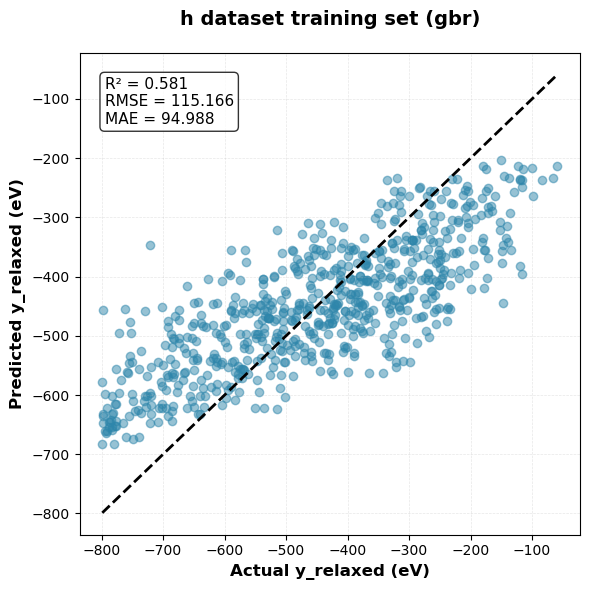

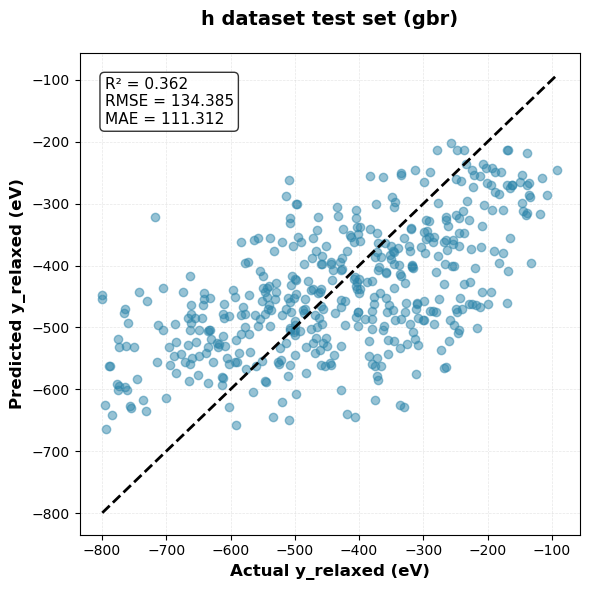

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


def parity_plot(X, y, model, title):
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    plt.figure(figsize=(6,6), dpi=100)
    plt.scatter(y, y_pred, alpha=0.5, color='#2E86AB')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    metrics_text = f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}'
    plt.text(0.05, 0.95, metrics_text, 
             transform=plt.gca().transAxes,
             fontsize=11,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.xlabel('Actual y_relaxed (eV)', fontsize=12, fontweight='bold')
    plt.ylabel('Predicted y_relaxed (eV)', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

h_X = h.drop(columns='y_relaxed')
h_y = h['y_relaxed']

h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(
    h_X, 
    h_y, 
    test_size=0.4, 
    random_state=1065)

h_gbr = GradientBoostingRegressor(random_state = 1065)
# no_ads_gbr = GradientBoostingRegressor(random_state = 1065)

param_grid_basic = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 1.0]
}

param_grid_comprehensive = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None],
    'loss': ['squared_error', 'absolute_error', 'huber']
}

def rand_search_cv(X, y, model, param_grid):
    rand_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=100,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        random_state=1065,
    )

    rand_search.fit(X, y)
    return rand_search

h_cv = rand_search_cv(X=h_X_train, y=h_y_train, model=h_gbr, param_grid=param_grid_basic)
h_best_gbr_model = h_cv.best_estimator_
print(h_cv.best_estimator_)

parity_plot(h_X_train, h_y_train, h_best_gbr_model, "h dataset training set (gbr)")
parity_plot(h_X_test, h_y_test, h_best_gbr_model, "h dataset test set (gbr)")

Stage 1: Coarse parameter search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Stage 1 best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Stage 1 best CV R²: 0.334

Stage 2: Fine-tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Final best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 12, 'n_estimators': 200}
Final best CV R²: 0.350
Train R²: 0.675
Test R²: 0.368


/Users/hliu/miniconda3/envs/ocp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/hliu/miniconda3/envs/ocp/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/hliu/miniconda3/envs/ocp/lib/python3.12/site-packages/sklearn/base.py", line 1358, in wrapper
    estimator._validate_params()
  File "/Users/hliu/miniconda3/envs/ocp/lib/python3.12/site-packages/sklearn/base.py", line 471, in _validate_params
    validate

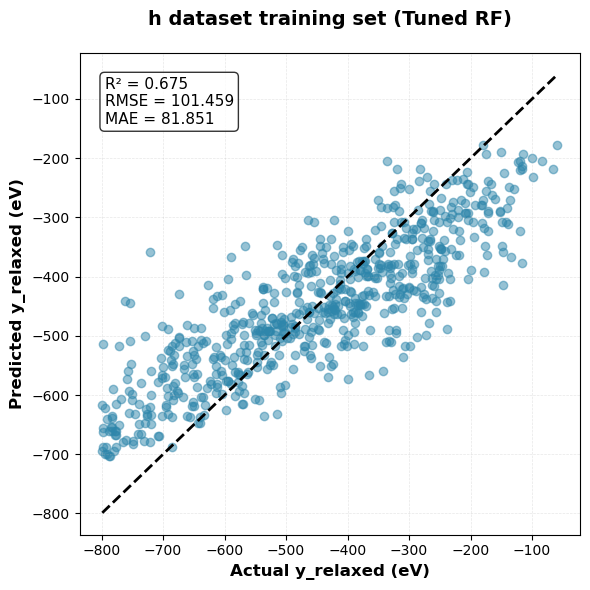

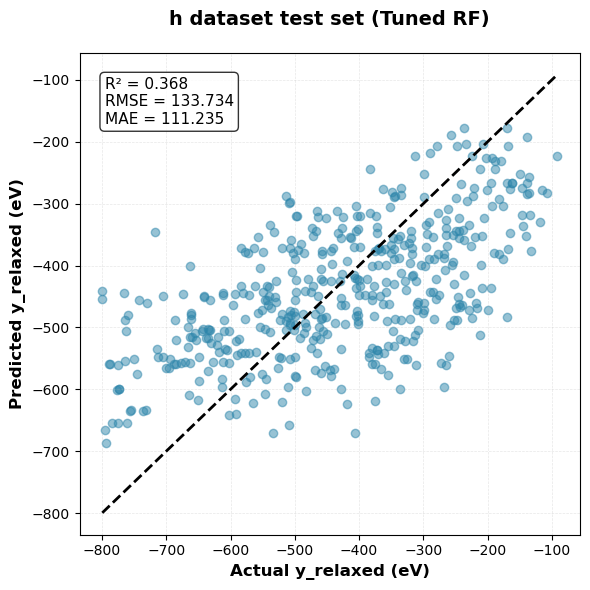

In [26]:
# Stage 1: Coarse search
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


print("Stage 1: Coarse parameter search...")
param_grid_coarse = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_coarse = GridSearchCV(rf, param_grid_coarse, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_coarse.fit(h_X_train, h_y_train)

print(f"Stage 1 best params: {grid_coarse.best_params_}")
print(f"Stage 1 best CV R²: {grid_coarse.best_score_:.3f}")

# Stage 2: Fine-tune around best parameters
best_params = grid_coarse.best_params_

param_grid_fine = {
    'n_estimators': [best_params['n_estimators'] - 100, 
                     best_params['n_estimators'], 
                     best_params['n_estimators'] + 100],
    'max_depth': [best_params['max_depth']] if best_params['max_depth'] is not None 
                 else [20, 30, None],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 2),
                          best_params['min_samples_split'],
                          best_params['min_samples_split'] + 2],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1),
                         best_params['min_samples_leaf'],
                         best_params['min_samples_leaf'] + 1],
    'max_features': ['sqrt', 'log2', None]
}

print("\nStage 2: Fine-tuning...")
grid_fine = GridSearchCV(rf, param_grid_fine, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_fine.fit(h_X_train, h_y_train)

print(f"\nFinal best parameters: {grid_fine.best_params_}")
print(f"Final best CV R²: {grid_fine.best_score_:.3f}")

best_rf = grid_fine.best_estimator_
print(f"Train R²: {best_rf.score(h_X_train, h_y_train):.3f}")
print(f"Test R²: {best_rf.score(h_X_test, h_y_test):.3f}")

# Visualize
parity_plot(h_X_train, h_y_train, best_rf, "h dataset training set (Tuned RF)")
parity_plot(h_X_test, h_y_test, best_rf, "h dataset test set (Tuned RF)")